In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

# from aijack.attack import GAN_Attack
from aijack.collaborative import FedAvgClient, FedAvgServer
from aijack.utils import NumpyDataset

In [2]:
batch_size = 3

class LeNet(nn.Module):
    def __init__(self, channel=3, hideen=768, num_classes=10):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            nn.BatchNorm2d(12),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            nn.BatchNorm2d(12),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            nn.BatchNorm2d(12),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(hideen, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def prepare_dataloaders():
    at_t_dataset_train = torchvision.datasets.MNIST(
        root="./", train=True, download=True
    )
    at_t_dataset_test = torchvision.datasets.MNIST(
        root="./", train=False, download=True
    )

    X = at_t_dataset_train.data.numpy()
    y = at_t_dataset_train.targets.numpy()

    # ToTensor：画像のグレースケール化（RGBの0~255を0~1の範囲に正規化）、Normalize：Z値化（RGBの平均と標準偏差を0.5で決め打ちして正規化）
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )

    # idx_1 = random.sample(range(400), 200)
    # idx_2 = list(set(range(400)) - set(idx_1))
    idx_1 = np.where(y < 5)[0]
    idx_2 = np.where(y >= 5)[0]

    global_trainset = NumpyDataset(
        at_t_dataset_test.data.numpy(),
        at_t_dataset_test.targets.numpy(),
        transform=transform,
    )
    global_trainloader = torch.utils.data.DataLoader(
        global_trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    trainset_1 = NumpyDataset(X[idx_1], y[idx_1], transform=transform)
    trainloader_1 = torch.utils.data.DataLoader(
        trainset_1, batch_size=batch_size, shuffle=True, num_workers=2
    )
    trainset_2 = NumpyDataset(X[idx_2], y[idx_2], transform=transform)
    trainloader_2 = torch.utils.data.DataLoader(
        trainset_2, batch_size=batch_size, shuffle=True, num_workers=2
    )

    return X, y, [trainloader_1, trainloader_2], global_trainloader, [200, 200]

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
print(device)

X, y, trainloaders, global_trainloader, dataset_nums = prepare_dataloaders()

cpu


In [4]:
from aijack.collaborative import FedAvgClient, FedAvgServer

shape_img = (28, 28)
num_classes = 10
channel = 1
hidden = 588

net_1 = LeNet(channel=channel, hideen=hidden, num_classes=num_classes)
net_2 = LeNet(channel=channel, hideen=hidden, num_classes=num_classes)
global_model = LeNet(channel=channel, hideen=hidden, num_classes=num_classes)

clients = [FedAvgClient(net_1, user_id=0), FedAvgClient(net_2, user_id=1)]
optimizers = [optim.SGD(clients[0].parameters(), lr=0.02, weight_decay=1e-7, momentum=0.9), optim.SGD(clients[1].parameters(), lr=0.02, weight_decay=1e-7, momentum=0.9)]
server = FedAvgServer(clients, global_model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
        server.parameters(), lr=0.02, weight_decay=1e-7, momentum=0.9
    )

# for epoch in range(3):
#     print(epoch)
#     for client, local_trainloader, local_optimizer in zip(clients, trainloaders, optimizers):
#         for data in local_trainloader:
#             inputs, labels = data
#             local_optimizer.zero_grad()
#             outputs = client(inputs)
#             loss = criterion(outputs, labels.to(torch.int64))
#             client.backward(loss)
#             optimizer.step()
#             print(loss)
#     server.action()

In [5]:
from aijack.attack import GradientInversion_Attack, GradientInversionAttackManager

# # DLG Attack (Zhu, Ligeng, Zhijian Liu, and Song Han. "Deep leakage from gradients." Advances in Neural Information Processing Systems 32 (2019).)
# dlg_manager = GradientInversionAttackManager((1, 28, 28), distancename="l2")
# FedAvgServer_DLG = dlg_manager.attach(FedAvgServer)

# # GS Attack (Geiping, Jonas, et al. "Inverting gradients-how easy is it to break privacy in federated learning?." Advances in Neural Information Processing Systems 33 (2020): 16937-16947.)
# gs_manager = GradientInversionAttackManager((1, 28, 28), distancename="cossim", tv_reg_coef=0.01)
# FedAvgServer_GS = gs_manager.attach(FedAvgServer)

# iDLG (Zhao, Bo, Konda Reddy Mopuri, and Hakan Bilen. "idlg: Improved deep leakage from gradients." arXiv preprint arXiv:2001.02610 (2020).)
idlg_manager = GradientInversionAttackManager((1, 28, 28), distancename="l2", num_iteration=1000, optimize_label=False)
FedAvgServer_iDLG = idlg_manager.attach(FedAvgServer)

# # CPL (Wei, Wenqi, et al. "A framework for evaluating gradient leakage attacks in federated learning." arXiv preprint arXiv:2004.10397 (2020).)
# cpl_manager = GradientInversionAttackManager((1, 28, 28), distancename="l2", optimize_label=False, lm_reg_coef=0.01)
# FedAvgServer_CPL = cpl_manager.attach(FedAvgServer)

# # GradInversion (Yin, Hongxu, et al. "See through gradients: Image batch recovery via gradinversion." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2021.)
# gi_manager = GradientInversionAttackManager((1, 28, 28), distancename="l2", optimize_label=False, bn_reg_layers=[global_model.body[1], global_model.body[4], global_model.body[7]],
#                                     group_num = 5, tv_reg_coef=0.00, l2_reg_coef=0.0001, bn_reg_coef=0.001, gc_reg_coef=0.001)
# FedAvgServer_GI = gi_manager.attach(FedAvgServer)

server = FedAvgServer_iDLG(clients, global_model, lr=0.02)
# --- normal federated learning --- #
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
        server.parameters(), lr=0.02, weight_decay=1e-7, momentum=0.9
    )


for client, local_trainloader, local_optimizer in zip(clients, trainloaders, optimizers):
    for data in local_trainloader:
        inputs, labels = data
        local_optimizer.zero_grad()
        outputs = client(inputs)
        loss = criterion(outputs, labels.to(torch.int64))
        client.backward(loss)
        optimizer.step()
    
server.action()
reconstructed_image, reconstructed_label = server.attack()

iter=10: 71.49229431152344, (best_iter=10: 71.49229431152344)
iter=20: 70.78050231933594, (best_iter=20: 70.78050231933594)
iter=30: 70.54597473144531, (best_iter=30: 70.54597473144531)
iter=40: 70.5264892578125, (best_iter=40: 70.5264892578125)
iter=50: 70.52376556396484, (best_iter=50: 70.52376556396484)
iter=60: 70.52336883544922, (best_iter=60: 70.52336883544922)
iter=70: 70.52311706542969, (best_iter=70: 70.52311706542969)
iter=80: 70.52298736572266, (best_iter=80: 70.52298736572266)
iter=90: 70.52283477783203, (best_iter=89: 70.5228271484375)
iter=100: 70.52275085449219, (best_iter=98: 70.52275085449219)
iter=110: 70.52272033691406, (best_iter=106: 70.52272033691406)
iter=120: 70.5226821899414, (best_iter=113: 70.5226821899414)
iter=130: 70.52265930175781, (best_iter=129: 70.52265930175781)
iter=140: 70.52265930175781, (best_iter=133: 70.52265167236328)
iter=150: 70.52264404296875, (best_iter=143: 70.52264404296875)
iter=160: 70.52262878417969, (best_iter=159: 70.52261352539062)


Text(0.5, 1.0, '0')

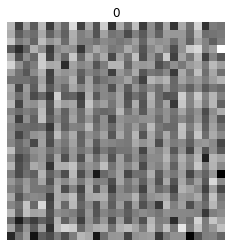

In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.imshow(reconstructed_image.detach().numpy()[0][0], cmap="gray")
ax1.axis("off")
ax1.set_title(reconstructed_label.item())